# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [195]:
import pandas as pd
import numpy as np
import math
import json
#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Explore the data

In [108]:
print(portfolio.info())
portfolio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes
None


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [109]:
print(profile.info())
profile.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [110]:
print(transcript.info())
transcript.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


## Process data


**transcript**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

Our goal with this data set is to exract the value column to separate columns for each value. Also we want to split the different events into separate columns. We do not remove duplicates since a person could have a certain event with certain values multiple times. Still, person should be renamed with customer_id to have good naming convention.

In [196]:
# extract value column from transcript 
# be careful, for offer completed the id is named offer_id, for the others offer id
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id'))
transcript['offer_id_completed'] = transcript['value'].apply(lambda x: x.get('offer_id'))
transcript['offer_id'] = transcript['offer_id'].fillna(transcript['offer_id_completed'])
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward'))
transcript = transcript.drop(['value', 'offer_id_completed'], axis=1)
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [198]:

transcript[transcript['event']== 'offer viewed']

,person,event,time,offer_id,amount,reward
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,NaN
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
...,...,...,...,...,...,...
306441,d56386cf344c4829bbf420d1895dca37,offer viewed,714,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
306450,9b51e8797290403b90d09d864dec4b94,offer viewed,714,3f207df678b143eea3cee63160fa8bed,NaN,NaN
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,714,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,714,3f207df678b143eea3cee63160fa8bed,NaN,NaN


In [199]:
# we introduce dummies for event
print(transcript.event.value_counts())
event_dummies = pd.get_dummies(transcript.event)
event_dummies.columns=['offer_completed', 'offer_received', 'offer_viewed', 'transaction']
transcript = pd.concat([transcript, event_dummies], axis=1)
transcript = transcript.drop(['event'], axis=1)
transcript.head()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


,person,time,offer_id,amount,reward,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0


In [200]:
# only NAs in offer_id, amount and reward -> can replace them with zero
print(transcript.isnull().sum())
transcript = transcript.fillna(0)
transcript.isnull().sum()

person                  0
time                    0
offer_id           138953
amount             167581
reward             272955
offer_completed         0
offer_received          0
offer_viewed            0
transaction             0
dtype: int64


person             0
time               0
offer_id           0
amount             0
reward             0
offer_completed    0
offer_received     0
offer_viewed       0
transaction        0
dtype: int64

In [201]:
# rename column person to customer_id to have consistent naming
transcript = transcript.rename(columns = {'person': 'customer_id'})
transcript.head()

,customer_id,time,offer_id,amount,reward,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,0,1,0,0


**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

Here we want to split the channels into variables. Also there are no NAs included in the dataset.

In [204]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [205]:
# expand channels column
dummies_channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, dummies_channels], axis=1)


In [206]:
# rename id
portfolio = portfolio.drop(['channels'], axis=1)
portfolio = portfolio.rename(columns = {'id': 'offer_id'})
# also rename reward to reward_amount because we do not want variables named equal in two datasets while they don't tell the same
portfolio = portfolio.rename(columns = {'reward': 'reward_amount'})
portfolio

,reward_amount,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


Now we have a clean portfolio data set where we know for each offer type the specific channel. We also renamed the column id to offer_id, since it is also labelled like that in the transcript data set and we want to stay consistent

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In this data set we want to change the became_member_on column to date format, the id should be renamed with customer_id for good naming convention and we have to deal with NAs.

In [207]:
# change col to datetime choosing an appropriate format
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [208]:
# renaming id to customer_id for consistency
profile = profile.rename(columns = {'id': 'customer_id'})

What do do with the NAs? for income it makes sense to fill mith the mean. For gender we just don't know which gender the person is and don't want to allocate a gender, so we just set it to 'unknown', since it is a categorical variable anyway.

In [209]:
profile.isnull().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
dtype: int64

In [210]:
profile.gender = profile.gender.fillna('unknown')
profile.income = profile.income.fillna(profile.income.mean())

In [543]:
profile.head()

,age,customer_id,income,days_registered,F,M,O,unknown
0,54.619478,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2025,0,0,0,1
1,55.000000,0610b486422d4921ae7d2bf64640c50b,112000.000000,1872,1,0,0,0
2,54.619478,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,1510,0,0,0,1
3,75.000000,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,1939,1,0,0,0
4,54.619478,a03223e636434f42ac4c3df47e8bac43,65404.991568,1852,0,0,0,1


In [212]:
# check whether there are duplicates
profile.duplicated().sum()

0

Now we can join it all together to have all the relevant information additional to transactions in one dataset we call df_final.

In [213]:
df = transcript.merge(profile, how = 'left', on = 'customer_id')
df_final = df.merge(portfolio, how = 'left', on = 'offer_id')
df_final.head()

,customer_id,time,offer_id,amount,reward,offer_completed,offer_received,offer_viewed,transaction,gender,...,became_member_on,income,reward_amount,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,0,1,0,0,F,...,2017-05-09,100000.000000,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0,1,0,0,unknown,...,2017-08-04,65404.991568,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,0,1,0,0,M,...,2018-04-26,70000.000000,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,0,1,0,0,unknown,...,2017-09-25,65404.991568,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,0,1,0,0,unknown,...,2017-10-02,65404.991568,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


In [214]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   time              306534 non-null  int64         
 2   offer_id          306534 non-null  object        
 3   amount            306534 non-null  float64       
 4   reward            306534 non-null  float64       
 5   offer_completed   306534 non-null  uint8         
 6   offer_received    306534 non-null  uint8         
 7   offer_viewed      306534 non-null  uint8         
 8   transaction       306534 non-null  uint8         
 9   gender            306534 non-null  object        
 10  age               306534 non-null  int64         
 11  became_member_on  306534 non-null  datetime64[ns]
 12  income            306534 non-null  float64       
 13  reward_amount     167581 non-null  float64       
 14  diff

We only have NAs in variables coming from the portfolio dataset, which is what we expected, since it delivers only information for offer_received.

## Data Visualizations and further exploration
We can dive deeper into the profile and transcript data sets and see whether we can make some observations from descriptivie statistics. The portfolio data set just provides some information about the offers and is very small so we will concentrate on the others

### Profile
We will investigate the distributions of age, gender, income and became_member on and evaluate the observations

M          0.499059
F          0.360529
unknown    0.127941
O          0.012471
Name: gender, dtype: float64


<AxesSubplot:>

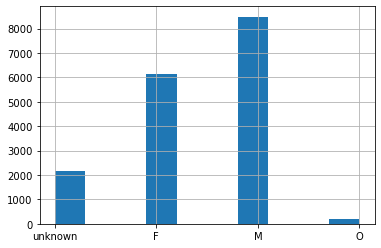

In [138]:
print(profile.gender.value_counts()/ len(profile.gender))

profile.gender.hist()

### Observations:
- almost 50% of the customers are male a lot more than female, so we could assume that the typical starbucks customer is more likely male
- but we should also take into account that more than 12% didn't quote their gender. It is not likely but if almost all of these people are women, then the distribution along gender would be quite equal
- but based on the data we assume most of the customers to be male (although we shouldn't forget about the second option)

62.53141176470588
58.0
55.0
54.39352445193929


<AxesSubplot:>

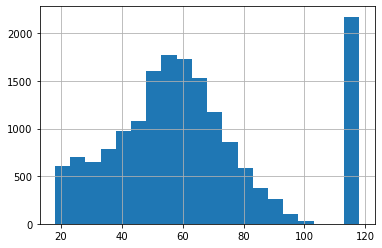

In [145]:
print(profile.age.mean())
print(profile.age.median())
print(profile[profile.age != 118].age.median())
print(profile[profile.age != 118].age.mean())


profile.age.hist(bins = 20)

### Observations:
- most of the customers are between 45 and 65 and a lot of customers are stated as aged 118 where we know from the description of the project that these are customers that didn't quote their age
- therefore it doesn't really makes sense to have a look at the mean, since it is a lot higher than in reality (assuming that these people are not all 118, which should be quite obvious)
- the median of the whole dataset is 58, which is way lower than the mean and in this case a better KPI. Nevertheless it makes sense to exclude all people aged 118 and have another look at the KPIS. The mean and median are both around 55, which is what we expect having a look at the histogram

65404.9915682968
65404.99156829799
120000.0
30000.0


<AxesSubplot:>

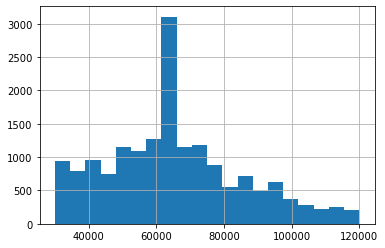

In [152]:
print(profile.income.median())
print(profile.income.mean())
print(profile.income.max())
print(profile.income.min())



profile.income.hist(bins = 20)

### Observations:
- we see that the income is distributet quite well from around 30k to 120k with not many outliers except one at the mean
- this totally makes sense since we filled the missing values with the mean. Also the median takes the same value
- what we can say is that the income of the customers has a broad variety and starbucks has customers in all classes of income
- since the min is exactly 30k and the max 120k we assume that there was a dropdown with certain values to choose for the income

2013-07-29 00:00:00
2018-07-26 00:00:00


<AxesSubplot:>

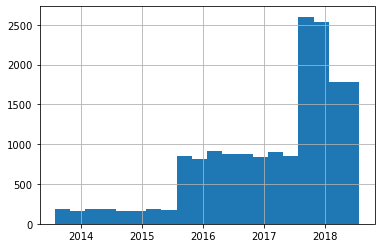

In [162]:
print(profile.became_member_on.min())
print(profile.became_member_on.max())

# plot hist (20 bins because we have data for 5 years, so each bin represents timespan of a quarter)
profile.became_member_on.hist(bins = 20)

### Observations:
- we have data for customers registering from mid 2013 to mid 2018
- we see that registrations in the first two years are quite constant on a low level, the following 2 years registrations increased a lot, but where also on a high level. The last year is split, the first half, registrations increased further, in the second half they decreased a little bit, but still on a higher level as in the years before.

### Transcript

We will make a funnel analysis to find out how many customers received an offer, viewed it and then completed it. We do this for every offer_id. We are also interested in the offer type, so we will use our final data set.

In [241]:
funnel_type = pd.DataFrame(df_final[df_final['offer_id'] != 0].groupby('offer_type').offer_received.sum())
funnel_type['offer_viewed'] = df_final[df_final['offer_id'] != 0].groupby('offer_type').offer_viewed.sum()
funnel_type['offer_completed'] = df_final[df_final['offer_id'] != 0].groupby('offer_type').offer_completed.sum()
funnel_type

,offer_received,offer_viewed,offer_completed
offer_type,,,
bogo,30499.0,25449.0,15669.0
discount,30543.0,21445.0,17910.0
informational,15235.0,10831.0,0.0


In [242]:
funnel_offer = pd.DataFrame(df_final[df_final['offer_id'] != 0].groupby(['offer_id', 'offer_type']).offer_received.sum())
funnel_offer['offer_viewed'] = df_final[df_final['offer_id'] != 0].groupby(['offer_id', 'offer_type']).offer_viewed.sum()
funnel_offer['offer_completed'] = df_final[df_final['offer_id'] != 0].groupby(['offer_id', 'offer_type']).offer_completed.sum()
funnel_offer

,,offer_received,offer_viewed,offer_completed
offer_id,offer_type,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,7668.0,2663.0,3420.0
2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7646.0,7337.0,5156.0
2906b810c7d4411798c6938adc9daaa5,discount,7632.0,4118.0,4017.0
3f207df678b143eea3cee63160fa8bed,informational,7617.0,4144.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,7593.0,7298.0,3331.0
5a8bc65990b245e5a138643cd4eb9837,informational,7618.0,6687.0,0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7677.0,4171.0,4354.0
ae264e3637204a6fb9bb56bc8210ddfd,bogo,7658.0,6716.0,3688.0
f19421c1d4aa40978ebb69ca19b0e20d,bogo,7571.0,7264.0,4296.0


### Observations:
- the distribution of the different offers received is quite equal through the different offer types
- the most viewed offer_type is bogo
- there are two offer types, one discount and one bogo which are more often completed than viewed. This suggests that there useres completing an offer without ever viewing it. These are the users we don't want to send an offer
- The offers users respond most to are two discount offers, one with difficulty 7 and one with 10. The offer with difficulty 20 is the one with the least response rate, which suggests that most of the customers don't spend that much.

Now we can plot the data and have a look at the funnel for each type and offer.

<AxesSubplot:xlabel='offer_id,offer_type'>

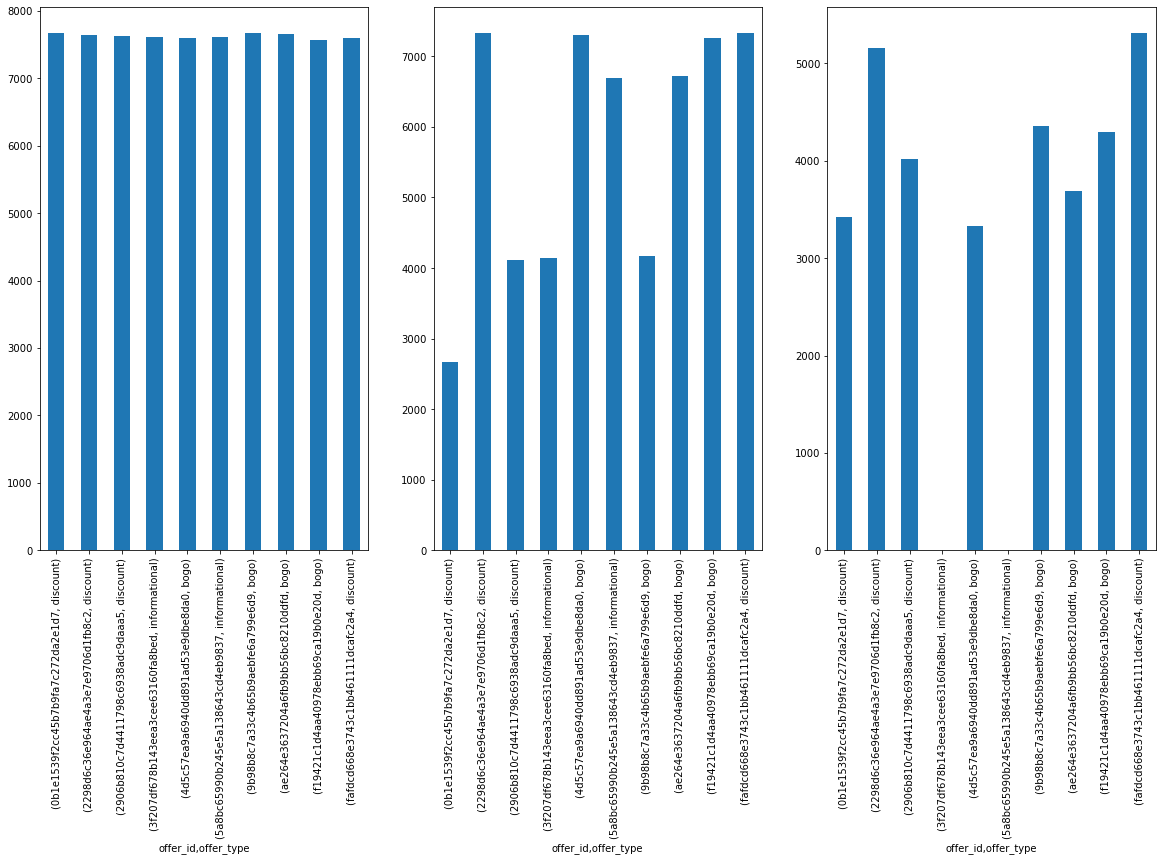

In [274]:
import matplotlib.pyplot as plt

plt.subplot(131)
funnel_offer.offer_received.plot(kind='bar', figsize=(20,10))

plt.subplot(132)
funnel_offer.offer_viewed.plot(kind='bar', figsize=(20,10))

plt.subplot(133)
funnel_offer.offer_completed.plot(kind='bar', figsize=(20,10))

    

<AxesSubplot:xlabel='offer_type'>

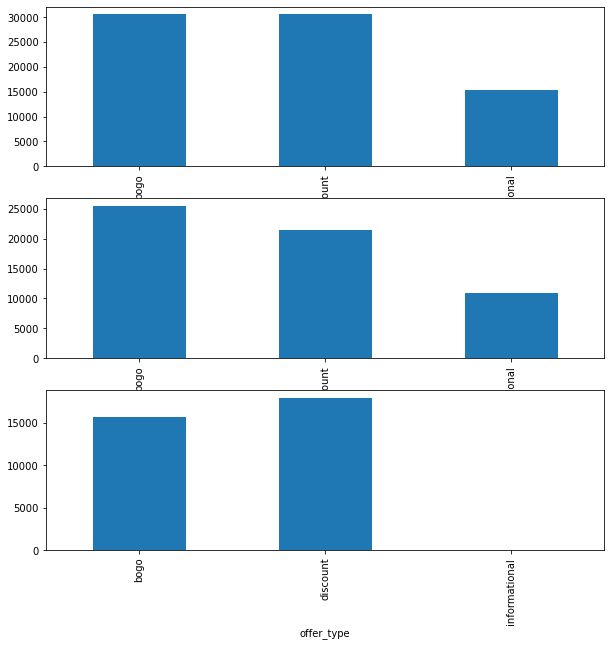

In [275]:
fig, axes = plt.subplots(nrows=3, ncols=1)


funnel_type.offer_received.plot(kind='bar', figsize=(10,10), ax=axes[0], xlabel=None)

funnel_type.offer_viewed.plot(kind='bar', figsize=(10,10), ax=axes[1])

funnel_type.offer_completed.plot(kind='bar', figsize=(10,10), ax=axes[2])

Another interesting KPI is the distribution of the average amount of a transaction.

11.223732377556
138953
138247


<AxesSubplot:>

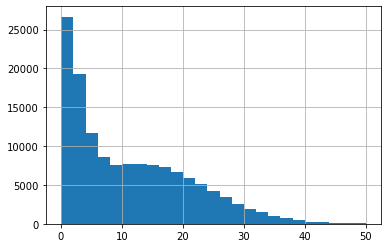

In [554]:
print(df_final[(df_final['transaction']==1) & (df_final['amount']< 50)].amount.mean())
print(df_final[(df_final['transaction']==1)].amount.count())
print(df_final[(df_final['transaction']==1) & (df_final['amount']< 50)].amount.count())

# plotting only values less than 50 the plot is easier to view and interpret
df_final[(df_final['transaction']==1) & (df_final['amount']< 50)].amount.hist(bins=25)


In [215]:
portfolio

,reward_amount,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


## Building a model for sending the best offer

For building a model we want have to state the problem first. Our goal is to send the best offers to the customers. Therefore we want to predict for each offer type whether an offer is completed or not. An informational offer is completed if the customer makes a transaction within the duration time. For bogo and discount offers it is a little bit easier. If the customer completes the offer without viewing it we assume he would have made the transactions anyway so we don't want to send an offer in future. We split the problem for the 3 different offer types into 3 problems, each of them trying to predict whether the offer is completed or not. (in the sense of transactions are influenced by the offer).

This leads us to 3 **Logistic Regression problems**:

**should a customer receive an offer of a certain offer type?**

Therefore we first have to build a data set we can work with. Gender and became member on are still not numerics. For gender we want to get dummies, for became member on we want to know how long they are members. Probably we should also replace the 118 aged people by the mean.

In [283]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       306534 non-null  object        
 1   time              306534 non-null  int64         
 2   offer_id          306534 non-null  object        
 3   amount            306534 non-null  float64       
 4   reward            306534 non-null  float64       
 5   offer_completed   306534 non-null  uint8         
 6   offer_received    306534 non-null  uint8         
 7   offer_viewed      306534 non-null  uint8         
 8   transaction       306534 non-null  uint8         
 9   gender            306534 non-null  object        
 10  age               306534 non-null  int64         
 11  became_member_on  306534 non-null  datetime64[ns]
 12  income            306534 non-null  float64       
 13  reward_amount     167581 non-null  float64       
 14  diff

In [351]:
# we do that later with the profile data anyways, so the following 2 cells are more or less redundant
from datetime import datetime, timedelta
    
df_final['days_registered'] = (datetime.today() - df_final.became_member_on).dt.days
df_final['age'] = df_final.age.replace(118, df_final.age.mean())

In [352]:
final_dummies = pd.get_dummies(df_final.gender)
final_dummies.shape
df_reg = pd.concat([df_final, final_dummies], axis=1)
# also drop offer type
df_reg = df_reg.drop(['became_member_on', 'gender'], axis=1)
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      306534 non-null  object 
 1   time             306534 non-null  int64  
 2   offer_id         306534 non-null  object 
 3   amount           306534 non-null  float64
 4   reward           306534 non-null  float64
 5   offer_completed  306534 non-null  uint8  
 6   offer_received   306534 non-null  uint8  
 7   offer_viewed     306534 non-null  uint8  
 8   transaction      306534 non-null  uint8  
 9   age              306534 non-null  float64
 10  income           306534 non-null  float64
 11  reward_amount    167581 non-null  float64
 12  difficulty       167581 non-null  float64
 13  duration         167581 non-null  float64
 14  offer_type       167581 non-null  object 
 15  email            167581 non-null  float64
 16  mobile           167581 non-null  floa

## BOGO Regression model

In [612]:
# offers the customer received
offer_received = df_reg[(df_reg['offer_received'] == 1) & (df_reg['offer_type'] == 'bogo')][['customer_id', 'offer_id', 'time', 'duration']]
offer_received['expiring_time'] = offer_received.time + offer_received.duration * 24
offer_received.shape

(30499, 5)

In [613]:
# offers viewed
offer_viewed = df_reg[(df_reg['offer_viewed'] == 1) & (df_reg['offer_type'] == 'bogo')][['customer_id', 'offer_id', 'time']]
offer_viewed['view_time'] = offer_viewed.time
offer_viewed = offer_viewed.drop(['time'], axis=1)
offer_viewed.head()

,customer_id,offer_id,view_time
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0
12652,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0,0
12653,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd,0
12662,262ad0fb526a4d53b572007da60cce24,f19421c1d4aa40978ebb69ca19b0e20d,0
12664,182e68952b474700b171e21b85c258ac,f19421c1d4aa40978ebb69ca19b0e20d,0


In [614]:
# offers completed
offer_completed = df_reg[(df_reg['offer_completed'] == 1) & (df_reg['offer_type'] == 'bogo')][['customer_id', 'offer_id', 'time']]
offer_completed['completion_time'] = offer_completed.time
offer_completed = offer_completed.drop(['time'], axis=1)
offer_completed.head()

,customer_id,offer_id,completion_time
12679,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,0
12692,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,0
12717,227f2d69e46a4899b70d48182822cff6,4d5c57ea9a6940dd891ad53e9dbe8da0,0
12744,d72d201be5794279aa716d8ad82b8d90,f19421c1d4aa40978ebb69ca19b0e20d,0


In [615]:
#  transaction 
transactions = df_reg[(df_reg['transaction'] == 1)][['customer_id', 'time']]
transactions['transaction_time'] = transactions.time
transactions = transactions.drop(['time'], axis=1)
transactions.head()

,customer_id,transaction_time
12654,02c083884c7d45b39cc68e1314fec56c,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0
12659,54890f68699049c2a04d415abc25e717,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,0
12671,fe97aa22dd3e48c8b143116a8403dd52,0


We join the offer and transaction data together to have all the times next to eacht other.

In [616]:
received_viewed = offer_received.merge(offer_viewed, how='left', on=['customer_id', 'offer_id'])
received_viewed = received_viewed[(received_viewed['view_time']>=received_viewed['time'])|(received_viewed['view_time'].isnull())]
received_viewed = received_viewed[(received_viewed['view_time']<=received_viewed['expiring_time'])|(received_viewed['view_time'].isnull())]
received_viewed.shape

(30309, 6)

In [617]:
received_complete = received_viewed.merge(offer_completed, how = 'left', on=['customer_id', 'offer_id'])
print(received_complete.shape)
received_complete = received_complete[(received_complete['completion_time'] <= received_complete['expiring_time'])
                                     | (received_complete['completion_time'].isnull())]
received_complete = received_complete[(received_complete['completion_time'] >= received_complete['time'])
                                     | (received_complete['completion_time'].isnull())]
print(received_complete.shape)
received_complete.head()

(35076, 7)
(30046, 7)


,customer_id,offer_id,time,duration,expiring_time,view_time,completion_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0
1,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,5.0,120.0,84.0,NaN
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,5.0,120.0,0.0,60.0
5,1e9420836d554513ab90eba98552d0a9,ae264e3637204a6fb9bb56bc8210ddfd,0,7.0,168.0,96.0,NaN
6,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,48.0,12.0


In [618]:
df_bogo = received_complete.merge(transactions, how='left', on='customer_id')
print(df_bogo.shape)
df_bogo.head()

(258189, 8)


,customer_id,offer_id,time,duration,expiring_time,view_time,completion_time,transaction_time
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,132.0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,144.0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,222.0
3,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,240.0
4,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,378.0


Now we are searching for the transactions that where between view_time and completion_time, because we assume they where influenced by the offer. Then we count by how many offers the customer was influenced and how many he received.

In [619]:
df_bogo['influenced'] = np.where((df_bogo['view_time'] <= df_bogo['transaction_time']) & 
                                 (df_bogo.transaction_time <= df_bogo.completion_time), 1,0)
df_bogo.head()

,customer_id,offer_id,time,duration,expiring_time,view_time,completion_time,transaction_time,influenced
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,132.0,1
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,144.0,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,222.0,0
3,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,240.0,0
4,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,7.0,168.0,6.0,132.0,378.0,0


In [620]:
influence_count = pd.DataFrame(df_bogo[df_bogo['influenced'] == 1].groupby(['customer_id']).offer_id.nunique())
received = pd.DataFrame(offer_received.groupby(['customer_id']).offer_id.nunique())
received_influenced = received.merge(influence_count, how = 'left', left_index=True, right_index=True)
received_influenced = received_influenced.rename({'offer_id_x': 'received', 'offer_id_y': 'influenced'}, axis=1).fillna(0)
received_influenced.head()

,received,influenced
customer_id,,
0009655768c64bdeb2e877511632db8f,1,0.0
00116118485d4dfda04fdbaba9a87b5c,1,0.0
0011e0d4e6b944f998e987f904e8c1e5,1,1.0
0020c2b971eb4e9188eac86d93036a77,2,1.0
0020ccbbb6d84e358d3414a3ff76cffd,2,2.0


Here we have bogo offers. Since we only want to send it to customer that are really influenced by the offers, set the threshold for influenced/received >50%, meaning it's more likely the customer completes the offer. This will be our target variable for the model.


In [625]:
received_influenced['above_threshold'] = np.where(received_influenced['influenced']/received_influenced['received']>.7, 1,0)
received_influenced.head()

,received,influenced,above_threshold
customer_id,,,
0009655768c64bdeb2e877511632db8f,1,0.0,0
00116118485d4dfda04fdbaba9a87b5c,1,0.0,0
0011e0d4e6b944f998e987f904e8c1e5,1,1.0,1
0020c2b971eb4e9188eac86d93036a77,2,1.0,0
0020ccbbb6d84e358d3414a3ff76cffd,2,2.0,1


In [626]:
received_influenced = received_influenced.drop(['received', 'influenced'], axis=1)


Since we want to predict on demographic data, the profile data should include the features. Again, we have to modify the data (dummies and became_member_on).

In [628]:
profile['days_registered'] = (datetime.today() - profile.became_member_on).dt.days
profile['age'] = profile.age.replace(118, df_final.age.mean())
dummies = pd.get_dummies(profile.gender)
profile = pd.concat([profile, dummies], axis=1)
profile = profile.drop(['became_member_on', 'gender'], axis=1)
profile.head()


,age,customer_id,income,days_registered,F,M,O,unknown
0,54.619478,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2025,0,0,0,1
1,55.000000,0610b486422d4921ae7d2bf64640c50b,112000.000000,1872,1,0,0,0
2,54.619478,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,1510,0,0,0,1
3,75.000000,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,1939,1,0,0,0
4,54.619478,a03223e636434f42ac4c3df47e8bac43,65404.991568,1852,0,0,0,1


In [629]:
bogo_data = received_influenced.merge(profile, how='left', on = 'customer_id')
bogo_data.head()

,customer_id,above_threshold,age,income,days_registered,F,M,O,unknown
0,0009655768c64bdeb2e877511632db8f,0,33.000000,72000.000000,1957,0,1,0,0
1,00116118485d4dfda04fdbaba9a87b5c,0,54.619478,65404.991568,1588,0,0,0,1
2,0011e0d4e6b944f998e987f904e8c1e5,1,40.000000,57000.000000,1694,0,0,1,0
3,0020c2b971eb4e9188eac86d93036a77,0,59.000000,90000.000000,2370,1,0,0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,1,24.000000,60000.000000,2118,1,0,0,0


In [630]:
X = bogo_data.drop(['customer_id', 'above_threshold'], axis=1)
y = bogo_data['above_threshold']

In [631]:
# libraries we need
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [632]:
# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

# scale training data
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
# scale test data
X_test=scaler.fit_transform(X_test)

In [633]:
# make instance of the model
log_reg = LogisticRegression()

# train the model
log_reg.fit(X_train,y_train)

LogisticRegression()

In [634]:
# predict on test data
preds = log_reg.predict(X_test)
score = log_reg.score(X_test, y_test)
print(score)

0.7023121387283237


Our initial score is 67%, which is not that bad, with scaling the data we achieve 68%. For sure thats not ideal, but considering the data it looks quite ok. But lets have a try what we can obtain from a decisiontree. Since we have actually two classes, we use the DecisionTreeClassifier. If we increased the threshold when an offer influenced a customer or not to .7 instead of .5 we achieved a test accuracy of 70%.

In [635]:
from sklearn.tree import tree
 
dec_tree = tree.DecisionTreeClassifier()
dec_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [636]:
# predict on test data
preds = dec_tree.predict(X_test)
score = dec_tree.score(X_test, y_test)
print(score)

0.6445086705202312


Ok, the decision tree didn't work that well. We could go further and try to implement some deep learning models, but the question is, whether this is really necassary. The reason why we choose such a simple model is because I tried to simplify the input data as far as possible. Although a test accuracy of 68% is way better than random guessing it is for sure not optimal. As possibilities for further improvement it could make sense not to try to simplify the data set that much. But for the first approach it kind of works, so lets see, how we perform on the other two offer types

## Discount Regression Model

In [579]:
# offers the customer received
offer_received = df_reg[(df_reg['offer_received'] == 1) & (df_reg['offer_type'] == 'discount')][['customer_id', 'offer_id', 'time', 'duration']]
offer_received['expiring_time'] = offer_received.time + offer_received.duration * 24
offer_received.shape

(30543, 5)

In [580]:
# offers viewed
offer_viewed = df_reg[(df_reg['offer_viewed'] == 1) & (df_reg['offer_type'] == 'discount')][['customer_id', 'offer_id', 'time']]
offer_viewed['view_time'] = offer_viewed.time
offer_viewed = offer_viewed.drop(['time'], axis=1)
offer_viewed.head()

,customer_id,offer_id,view_time
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0
12660,8c7df0c393db488aac3e58b06a7ea5f9,2298d6c36e964ae4a3e7e9706d1fb8c2,0
12661,e528ceb341964128aaf58a59733ec2af,2298d6c36e964ae4a3e7e9706d1fb8c2,0
12663,53bac762af27471eb294ff89ca1bae2c,fafdcd668e3743c1bb461111dcafc2a4,0
12681,b818e955451b47db9fc8767fa45e464e,2298d6c36e964ae4a3e7e9706d1fb8c2,0


In [581]:
# offers completed
offer_completed = df_reg[(df_reg['offer_completed'] == 1) & (df_reg['offer_type'] == 'discount')][['customer_id', 'offer_id', 'time']]
offer_completed['completion_time'] = offer_completed.time
offer_completed = offer_completed.drop(['time'], axis=1)
offer_completed.head()

,customer_id,offer_id,completion_time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,0
12672,fe97aa22dd3e48c8b143116a8403dd52,fafdcd668e3743c1bb461111dcafc2a4,0
12721,bb0f25e23a4c4de6a645527c275cd594,2298d6c36e964ae4a3e7e9706d1fb8c2,0
12764,73ffefd41e9a4ca3ab26b2b3697c6eb7,2906b810c7d4411798c6938adc9daaa5,0
12786,24115a61df25473e84a8a03f3c98de1a,2906b810c7d4411798c6938adc9daaa5,0


In [582]:
#  transaction 
transactions = df_reg[(df_reg['transaction'] == 1)][['customer_id', 'time']]
transactions['transaction_time'] = transactions.time
transactions = transactions.drop(['time'], axis=1)
transactions.head()

,customer_id,transaction_time
12654,02c083884c7d45b39cc68e1314fec56c,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0
12659,54890f68699049c2a04d415abc25e717,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,0
12671,fe97aa22dd3e48c8b143116a8403dd52,0


In [583]:
received_viewed = offer_received.merge(offer_viewed, how='left', on=['customer_id', 'offer_id'])
received_viewed = received_viewed[(received_viewed['view_time']>=received_viewed['time'])|(received_viewed['view_time'].isnull())]
received_viewed = received_viewed[(received_viewed['view_time']<=received_viewed['expiring_time'])|(received_viewed['view_time'].isnull())]
received_viewed.head()

,customer_id,offer_id,time,duration,expiring_time,view_time
0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,6.0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,7.0,168.0,18.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,10.0,240.0,12.0
5,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,0,7.0,168.0,24.0
7,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,18.0


In [584]:
received_complete = received_viewed.merge(offer_completed, how = 'left', on=['customer_id', 'offer_id'])
print(received_complete.shape)
received_complete = received_complete[(received_complete['completion_time'] <= received_complete['expiring_time'])
                                     | (received_complete['completion_time'].isnull())]
received_complete = received_complete[(received_complete['completion_time'] >= received_complete['time'])
                                     | (received_complete['completion_time'].isnull())]
print(received_complete.shape)
received_complete.head()

(36909, 7)
(31490, 7)


,customer_id,offer_id,time,duration,expiring_time,view_time,completion_time
0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,6.0,NaN
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,7.0,168.0,18.0,NaN
2,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,10.0,240.0,12.0,NaN
3,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,0,7.0,168.0,24.0,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,18.0,NaN


In [585]:
df_discount = received_complete.merge(transactions, how='left', on='customer_id')
print(df_discount.shape)
df_discount.head()

(274171, 8)


,customer_id,offer_id,time,duration,expiring_time,view_time,completion_time,transaction_time
0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,6.0,NaN,234.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,6.0,NaN,264.0
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,6.0,NaN,612.0
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,7.0,168.0,18.0,NaN,288.0
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,7.0,168.0,18.0,NaN,294.0


In [586]:
df_discount['influenced'] = np.where((df_discount['view_time'] <= df_discount['transaction_time']) & 
                                 (df_discount.transaction_time <= df_discount.completion_time), 1,0)
df_discount.head()

,customer_id,offer_id,time,duration,expiring_time,view_time,completion_time,transaction_time,influenced
0,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,6.0,NaN,234.0,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,6.0,NaN,264.0,0
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,10.0,240.0,6.0,NaN,612.0,0
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,7.0,168.0,18.0,NaN,288.0,0
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,7.0,168.0,18.0,NaN,294.0,0


In [587]:
influence_count = pd.DataFrame(df_discount[df_discount['influenced'] == 1].groupby(['customer_id']).offer_id.nunique())
received = pd.DataFrame(offer_received.groupby(['customer_id']).offer_id.nunique())
received_influenced = received.merge(influence_count, how = 'left', left_index=True, right_index=True)
received_influenced = received_influenced.rename({'offer_id_x': 'received', 'offer_id_y': 'influenced'}, axis=1).fillna(0)
received_influenced.head()

,received,influenced
customer_id,,
0009655768c64bdeb2e877511632db8f,2,0.0
0011e0d4e6b944f998e987f904e8c1e5,2,2.0
0020c2b971eb4e9188eac86d93036a77,1,1.0
0020ccbbb6d84e358d3414a3ff76cffd,1,1.0
003d66b6608740288d6cc97a6903f4f0,2,1.0


In [588]:
received_influenced['above_threshold'] = np.where(received_influenced['influenced']/received_influenced['received']>.7, 1,0)
received_influenced.head()

,received,influenced,above_threshold
customer_id,,,
0009655768c64bdeb2e877511632db8f,2,0.0,0
0011e0d4e6b944f998e987f904e8c1e5,2,2.0,1
0020c2b971eb4e9188eac86d93036a77,1,1.0,1
0020ccbbb6d84e358d3414a3ff76cffd,1,1.0,1
003d66b6608740288d6cc97a6903f4f0,2,1.0,0


In [589]:
received_influenced = received_influenced.drop(['received', 'influenced'], axis=1)


In [590]:
discount_data = received_influenced.merge(profile, how='left', on = 'customer_id')
discount_data.head()

,customer_id,above_threshold,age,income,days_registered,F,M,O,unknown
0,0009655768c64bdeb2e877511632db8f,0,33.0,72000.0,1957,0,1,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,1,40.0,57000.0,1694,0,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,1,59.0,90000.0,2370,1,0,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,1,24.0,60000.0,2118,1,0,0,0
4,003d66b6608740288d6cc97a6903f4f0,0,26.0,73000.0,1896,1,0,0,0


In [591]:
X = discount_data.drop(['customer_id', 'above_threshold'], axis=1)
y = discount_data['above_threshold']


In [592]:
X.head()

,age,income,days_registered,F,M,O,unknown
0,33.0,72000.0,1957,0,1,0,0
1,40.0,57000.0,1694,0,0,1,0
2,59.0,90000.0,2370,1,0,0,0
3,24.0,60000.0,2118,1,0,0,0
4,26.0,73000.0,1896,1,0,0,0


In [593]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: above_threshold, dtype: int32

In [594]:
# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

# scale training data
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
# scale test data
X_test=scaler.fit_transform(X_test)

In [595]:
# make instance of the model
log_reg = LogisticRegression()

# train the model
log_reg.fit(X_train,y_train)

LogisticRegression()

In [596]:
# predict on test data
preds = log_reg.predict(X_test)
score = log_reg.score(X_test, y_test)
print(score)

0.678635147190009


In [597]:
dec_tree = tree.DecisionTreeClassifier()
dec_tree.fit(X_train,y_train)

# predict on test data
preds = dec_tree.predict(X_test)
score = dec_tree.score(X_test, y_test)
print(score)

0.6210972346119537


As we expect, the results a in the same range but slightly worse. Now we see how it works on informational offers. There we have to do a little bit finetuning on the initial data set again.

## Informational Regression Model

In [598]:
# offers the customer received
offer_received = df_reg[(df_reg['offer_received'] == 1) & (df_reg['offer_type'] == 'informational')][['customer_id', 'offer_id', 'time', 'duration']]
offer_received['expiring_time'] = offer_received.time + offer_received.duration * 24
offer_received.shape

(15235, 5)

In [599]:
# offers viewed
offer_viewed = df_reg[(df_reg['offer_viewed'] == 1) & (df_reg['offer_type'] == 'informational')][['customer_id', 'offer_id', 'time']]
offer_viewed['view_time'] = offer_viewed.time
offer_viewed = offer_viewed.drop(['time'], axis=1)
offer_viewed.head()

,customer_id,offer_id,view_time
12651,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837,0
12655,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0
12667,1a353048b0884fc5a0afa27677ef1e80,5a8bc65990b245e5a138643cd4eb9837,0
12673,c863af14b3654499b1caea5e640136d2,5a8bc65990b245e5a138643cd4eb9837,0
12676,50b92ea51e2649dfbf7120d5e554e991,5a8bc65990b245e5a138643cd4eb9837,0


There we have the first difference, customers can't complete the informational offer. So we say the customer is influenced by an offer, if he has a transaction between received and viewed and before the end of the expiring time. Transaction is the same as before, so no need to change anything here.

In [600]:
received_viewed = offer_received.merge(offer_viewed, how='left', on=['customer_id', 'offer_id'])
received_viewed = received_viewed[(received_viewed['view_time']>=received_viewed['time'])|(received_viewed['view_time'].isnull())]
received_viewed = received_viewed[(received_viewed['view_time']<=received_viewed['expiring_time'])|(received_viewed['view_time'].isnull())]
received_viewed.head()

,customer_id,offer_id,time,duration,expiring_time,view_time
0,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,NaN
1,c27e0d6ab72c455a8bb66d980963de60,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,18.0
3,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837,0,3.0,72.0,0.0
4,a5a6ef2b78a04ddc9f374dd7c7f60bff,5a8bc65990b245e5a138643cd4eb9837,0,3.0,72.0,6.0
5,6e04a90a0e074496b5f229eb1f553433,5a8bc65990b245e5a138643cd4eb9837,0,3.0,72.0,24.0


In [601]:
# now we can already merge the transactions
df_informational = received_viewed.merge(transactions, how='left', on='customer_id')
print(df_informational.shape)
df_informational.head()

(111081, 7)


,customer_id,offer_id,time,duration,expiring_time,view_time,transaction_time
0,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,NaN,216.0
1,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,NaN,378.0
2,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,NaN,456.0
3,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,NaN,570.0
4,c27e0d6ab72c455a8bb66d980963de60,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,18.0,18.0


This time only transactions completed between the view_time and the expiring_time are influenced by the offer, all others not.

In [602]:
df_informational['influenced'] = np.where((df_informational['view_time'] <= df_informational['transaction_time']) & 
                                 (df_informational.transaction_time <= df_informational.expiring_time), 1,0)
df_informational.head()

,customer_id,offer_id,time,duration,expiring_time,view_time,transaction_time,influenced
0,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,NaN,216.0,0
1,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,NaN,378.0,0
2,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,NaN,456.0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,NaN,570.0,0
4,c27e0d6ab72c455a8bb66d980963de60,3f207df678b143eea3cee63160fa8bed,0,4.0,96.0,18.0,18.0,1


In [603]:
influence_count = pd.DataFrame(df_informational[df_informational['influenced'] == 1].groupby(['customer_id']).offer_id.nunique())
received = pd.DataFrame(offer_received.groupby(['customer_id']).offer_id.nunique())
received_influenced = received.merge(influence_count, how = 'left', left_index=True, right_index=True)
received_influenced = received_influenced.rename({'offer_id_x': 'received', 'offer_id_y': 'influenced'}, axis=1).fillna(0)
received_influenced.head()

,received,influenced
customer_id,,
0009655768c64bdeb2e877511632db8f,2,2.0
0011e0d4e6b944f998e987f904e8c1e5,2,0.0
0020c2b971eb4e9188eac86d93036a77,1,0.0
0020ccbbb6d84e358d3414a3ff76cffd,1,1.0
003d66b6608740288d6cc97a6903f4f0,2,2.0


In [604]:
received_influenced['above_threshold'] = np.where(received_influenced['influenced']/received_influenced['received']>.7, 1,0)
received_influenced = received_influenced.drop(['received', 'influenced'], axis=1)
received_influenced.head()

,above_threshold
customer_id,
0009655768c64bdeb2e877511632db8f,1
0011e0d4e6b944f998e987f904e8c1e5,0
0020c2b971eb4e9188eac86d93036a77,0
0020ccbbb6d84e358d3414a3ff76cffd,1
003d66b6608740288d6cc97a6903f4f0,1


In [605]:
informational_data = received_influenced.merge(profile, how='left', on = 'customer_id')
informational_data.head()

,customer_id,above_threshold,age,income,days_registered,F,M,O,unknown
0,0009655768c64bdeb2e877511632db8f,1,33.0,72000.0,1957,0,1,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,0,40.0,57000.0,1694,0,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,0,59.0,90000.0,2370,1,0,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,1,24.0,60000.0,2118,1,0,0,0
4,003d66b6608740288d6cc97a6903f4f0,1,26.0,73000.0,1896,1,0,0,0


In [606]:
X = informational_data.drop(['customer_id', 'above_threshold'], axis=1)
y = informational_data['above_threshold']

In [607]:
# split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

# scale training data
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
# scale test data
X_test=scaler.fit_transform(X_test)

In [608]:
# make instance of the model
log_reg = LogisticRegression()

# train the model
log_reg.fit(X_train,y_train)

LogisticRegression()

In [609]:
# predict on test data
preds = log_reg.predict(X_test)
score = log_reg.score(X_test, y_test)
print(score)

0.6306477093206951


In [610]:
dec_tree = tree.DecisionTreeClassifier()
dec_tree.fit(X_train,y_train)

# predict on test data
preds = dec_tree.predict(X_test)
score = dec_tree.score(X_test, y_test)
print(score)

0.5576619273301737


We got a little worse again for the informational category, at least still a lot better than random guessing. We can also state that for this setup, logistic regression works better than the decision tree.

# Summary

After diving into the different data sets and going through the processing steps, the focus was on exploratory data analysis. There some visualizations and obtained results can be found in this notebook. After this step it was time to state the problem and get an idea how to solve it with the available data. I found this very challenging. After trying a variety of different ideas I tried to find a solution to the problem whether or not a customer should receive an offer of a certain type based on his demographic data. My goal was to simplify the data as far as possible for being able to use a more simple model. So I invested most of the work in cleaning and shuffeling the data how it was needed and then see what we can obtain from a simple model. The results may not look very good but in my opinion we could obtain some improvement with these models. Of course there is a lot of room for improvement...

## Further Improvements

There are several ideas for improvement:
- not only predict for a certain offer type but also for a certain offer.
- use other preprocessing idea to also access available data from already existing customers and not only for new customers based on demographic data
- use more complex, maybe even deep learning models with having more input features

## Acknowledges

First, I want to thank the udacity team for this great course and all the material and challenges. Of course also the mentors for being so supportive. And a big thanks to starbucks for providing the data and giving the opportunity to work with real world problems.